In [11]:
import numpy as np
import matplotlib.pyplot as plt
from wind2watts.fit.util import fit_to_df
import json
import pandas as pd

In [12]:
original = fit_to_df('../../data/strava_benchmark/Afternoon_Ride.fit')
no_power = fit_to_df('../../data/strava_benchmark/Afternoon_Ride_no_power.fit')

In [13]:
strava_data = json.load(open('../../data/strava_benchmark/watts_calc.json'))

In [14]:
pred_watts = np.array(strava_data['watts_calc'])

In [15]:
pred_watts_pos = pred_watts[pred_watts > 1]

In [16]:
original['power'].mean()

230.65592203898052

In [17]:
np.mean(pred_watts_pos)

193.9382470119522

In [29]:
import os
import torch
import joblib
from wind2watts.data.datasets import WindAnglePowerDataset
from wind2watts.models import SimpleRNN
from torch.utils.data import DataLoader

In [34]:
model_dir = '../../training_checkpoints/rel_wind_angle/simplernn_v1p0/'
best_model = SimpleRNN(4, 32)
best_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pt')))
best_model.eval()

SimpleRNN(
  (rnn): RNN(4, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

In [35]:
dataset = WindAnglePowerDataset(
    activities = [pd.read_csv('../../data/strava_benchmark/built/Afternoon_Ride.csv')],
    window_size = 5,
    window_scaler = joblib.load(os.path.join(model_dir, 'window_scaler.joblib')),
    power_scaler = joblib.load(os.path.join(model_dir, 'power_scaler.joblib')),
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

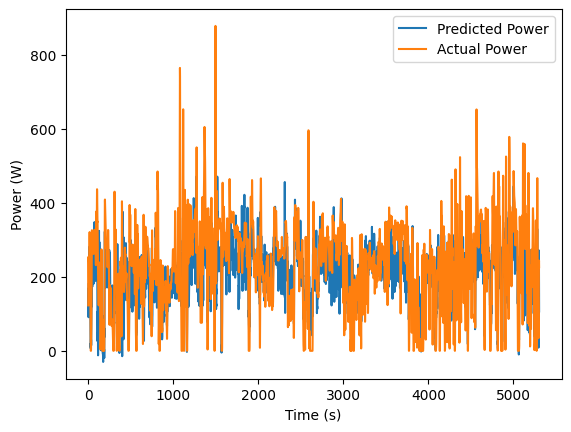

In [36]:
powers = []
pred_powers =  []
for (window, power) in dataloader:
    with torch.no_grad():
        power_pred = best_model(window)
    power_pred = dataset.power_scaler.inverse_transform(power_pred.cpu().numpy())
    power = dataset.power_scaler.inverse_transform(power.cpu().numpy())
    pred_powers.append(power_pred)
    powers.append(power)

powers = np.array(powers).reshape(-1)
pred_powers = np.array(pred_powers).reshape(-1)


plt.plot(pred_powers, label='Predicted Power')
plt.plot(powers, label='Actual Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend()

In [37]:
np.mean(pred_powers)

206.0513

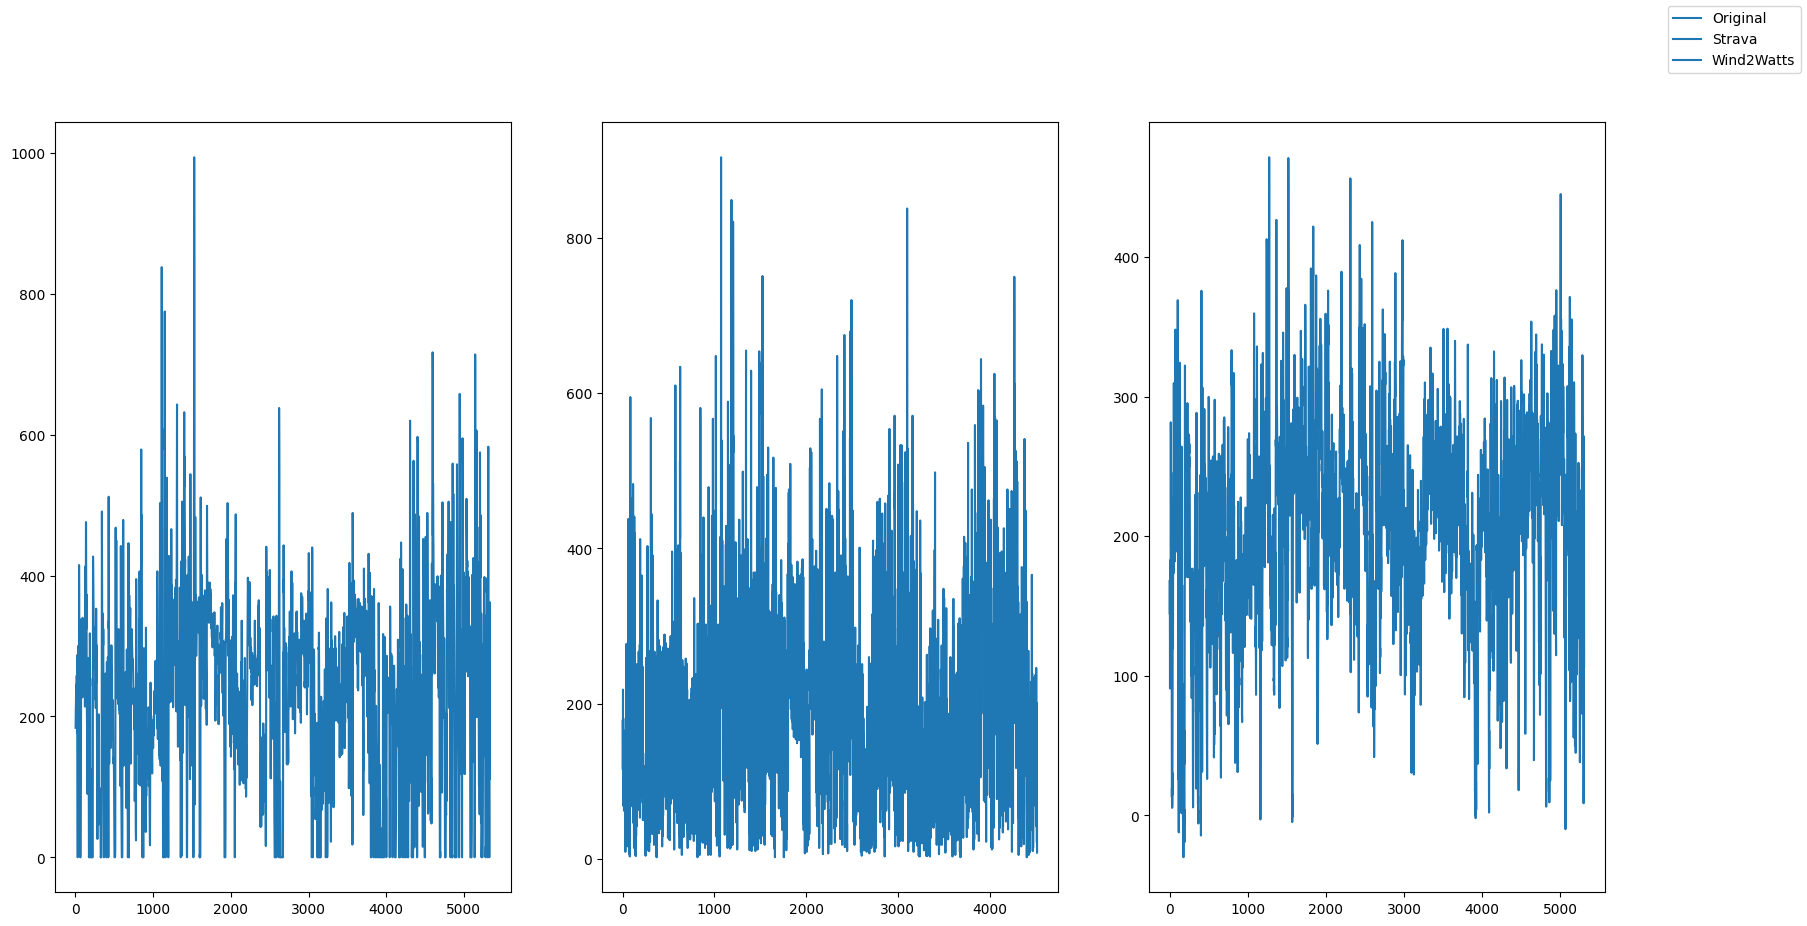

In [38]:
# Plot the original and strava side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].plot(original['power'], label='Original')
ax[1].plot(pred_watts_pos, label='Strava')
ax[2].plot(pred_powers, label='Wind2Watts')
fig.legend()